In [1]:
from ultralytics import YOLO
import supervision as sv
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
# Load the model
model = YOLO("best.pt")
model.fuse()

YOLO11s summary (fused): 100 layers, 9,414,735 parameters, 0 gradients, 21.3 GFLOPs


In [3]:
CLASS_NAME_DICT = model.model.names

CLASS_NAME_DICT

{0: 'Bus', 1: 'Car', 2: 'Motorcycle', 3: 'Truck', 4: 'TukTuk'}

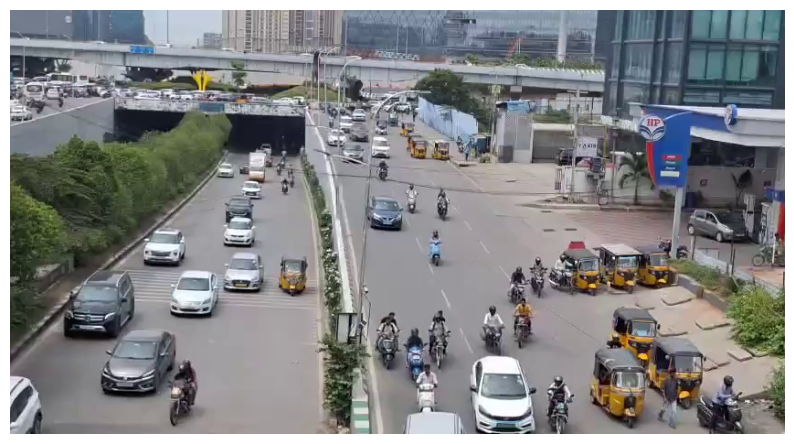

In [4]:
# create frame generator
generator = sv.get_video_frames_generator("Data\whatsapp video.mp4")

# get the first frame
iterator = iter(generator)
frame = next(iterator)

sv.plot_image(frame, (10, 10))

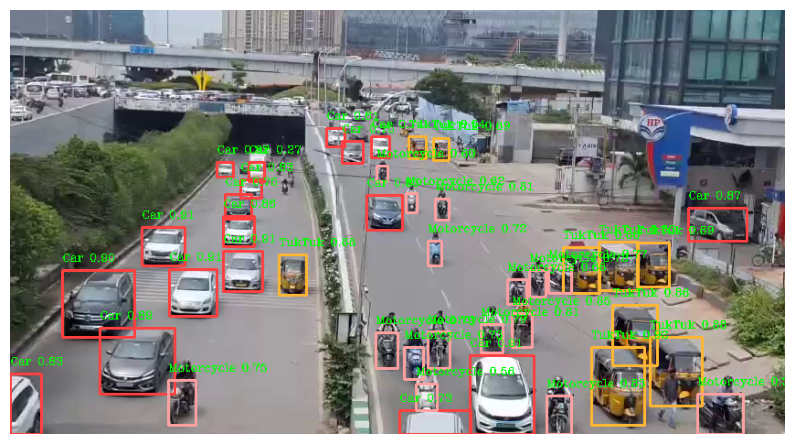

In [5]:
# detect vehicles from the frame
results = model(frame, verbose = False)[0]

# convert to detections
detections = sv.Detections.from_ultralytics(results)

# create instance of box annotator
box_annotator = sv.BoxAnnotator(thickness=2)

# annotate in the frame
annotated_frame = box_annotator.annotate(scene=frame.copy(), detections = detections)

# create labels
labels = []
for confidence, class_id in zip(detections.confidence, detections.class_id):
    label = f'{CLASS_NAME_DICT[class_id]} {confidence:0.2f}'
    labels.append(label)

# overlay labels in the boundingbox
for box, label in zip(detections.xyxy, labels):
    x1, y1, x2, y2 = box.astype(int)

    # display label above the box
    cv2.putText(
        annotated_frame, label, (x1, y1-10), fontFace = cv2.FONT_HERSHEY_COMPLEX, fontScale = 0.4, color=(0, 255, 0), thickness = 1
    )

sv.plot_image(annotated_frame, (10, 10))

In [6]:
sv.VideoInfo.from_video_path("Data\whatsapp video.mp4")

VideoInfo(width=848, height=464, fps=30, total_frames=7940)

In [7]:
# Line config 
LINE_START = sv.Point(0, 400)
LINE_END = sv.Point(800, 400)

# create bytetracker instance
byte_tracker = sv.ByteTrack(frame_rate = 30)

# create line conuter instance
line_counter = sv.LineZone(start = LINE_START, end = LINE_END)

# create line zone annotator
line_zone_annotator = sv.LineZoneAnnotator(thickness=1, text_thickness=1, text_scale=1)

# create box annotator
box_annotator = sv.BoxAnnotator(thickness=1)

# create trace annotator
trace_annotator = sv.TraceAnnotator(thickness=2, trace_length=60)

In [8]:
def process_frame(frame):
    # get results from model
    results = model(frame, verbose=False)[0]

    # convert to detections
    detections = sv.Detections.from_ultralytics(results)

    # tracking detection
    detections = byte_tracker.update_with_detections(detections)

    # create labels
    labels = []
    for confidence, class_id, tracker_id in zip(detections.confidence, detections.class_id, detections.tracker_id):
        label = f'{tracker_id} {CLASS_NAME_DICT[class_id]} {confidence:0.2f}'
        labels.append(label)

    # update trace annotator
    annotated_frame = trace_annotator.annotate(scene=frame.copy(), detections=detections)

    # update box annotator
    annotated_frame = box_annotator.annotate(scene=annotated_frame, detections=detections)

    # overlay labels in the boundingbox
    for box, label in zip(detections.xyxy, labels):
        x1, y1, x2, y2 = box.astype(int)

        # display label above the box
        cv2.putText(
            annotated_frame, label, (x1, y1-10), fontFace = cv2.FONT_HERSHEY_COMPLEX, fontScale = 0.4, color=(0, 255, 0), thickness = 1
        )

    line_counter.trigger(detections)

    #update line zone annotator
    annotated_frame = line_zone_annotator.annotate(annotated_frame, line_counter=line_counter)

    return annotated_frame

In [9]:
# Create dictionary to store counts for each vehicle type
vehicle_counts = {name: 0 for name in CLASS_NAME_DICT.values()}

def process_frame(frame):
    # get results from model
    results = model(frame, verbose=False)[0]

    # convert to detections
    detections = sv.Detections.from_ultralytics(results)

    # tracking detection
    detections = byte_tracker.update_with_detections(detections)

    # create labels
    labels = []
    for confidence, class_id, tracker_id in zip(detections.confidence, detections.class_id, detections.tracker_id):
        label = f'{tracker_id} {CLASS_NAME_DICT[class_id]} {confidence:0.2f}'
        labels.append(label)

    # update trace annotator
    annotated_frame = trace_annotator.annotate(scene=frame.copy(), detections=detections)

    # update box annotator
    annotated_frame = box_annotator.annotate(scene=annotated_frame, detections=detections)

    # overlay labels in the boundingbox
    for box, label in zip(detections.xyxy, labels):
        x1, y1, x2, y2 = box.astype(int)

        # display label above the box
        cv2.putText(
            annotated_frame, label, (x1, y1-10),
            fontFace = cv2.FONT_HERSHEY_COMPLEX, fontScale = 0.4,
            color=(0, 255, 0), thickness = 1
        )

    # detect line crossings
    crossed_in, crossed_out = line_counter.trigger(detections)

    # get the indices where True
    # in_indices = np.where(crossed_in)[0]
    out_indices = np.where(crossed_out)[0]

    # for det_idx in np.concatenate([in_indices, out_indices]):
    for det_idx in out_indices:
        class_id = int(detections.class_id[det_idx])
        class_name = CLASS_NAME_DICT[class_id]
        vehicle_counts[class_name] += 1

    # update line zone annotator
    annotated_frame = line_zone_annotator.annotate(annotated_frame, line_counter=line_counter)

    # also display vehicle counts on the frame
    y_offset = 30
    for cls, count in vehicle_counts.items():
        cv2.putText(
            annotated_frame, f"{cls}: {count}", (10, y_offset),
            fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.6,
            color=(0, 0, 255), thickness=2
        )
        y_offset += 25

    return annotated_frame

In [10]:
# run 
video_path = "Data\whatsapp video.mp4"

# get input from video
video_cap = cv2.VideoCapture(video_path)

while True:
    success, frame = video_cap.read()
    if not success:
        break

    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    processed_frame = process_frame(frame)

    #display
    cv2.imshow("test", processed_frame)

    # exit if any key pressed
    if cv2.waitKey(1) & 0xFF != 255:
        break

video_cap.release()
cv2.destroyAllWindows()